In [ ]:
# Transfer Learning for Parkinson’s Disease Detection via Speaker x-vectors
# Extracted x-vectors with a pretrained model and use them as fixed features for a downstream classifier.

# The LSTM-based model trained for Parkinson’s disease detection.

In [ ]:
# STEP 1: Install and Load Packages
!pip install git+https://github.com/speechbrain/speechbrain.git@develop torchaudio datasets pandas matplotlib seaborn scikit-learn --quiet

# STEP 2: Load Dataset and Save WAV Files
from datasets import load_dataset
import torchaudio, torch, os
import pandas as pd
import time

print("Loading dataset...")
dataset = load_dataset("birgermoell/Italian_Parkinsons_Voice_and_Speech", split="train")

os.makedirs("/content/parkinsons_xvect_experiment/audio", exist_ok=True)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Loading dataset...


Resolving data files:   0%|          | 0/833 [00:00<?, ?it/s]

In [ ]:
# folders = set()
# folders2 = set()
# for i in range(500):
#     path = dataset[i]['audio']['path']
#     folder = path.split('/')[-3]
#     folder1 = path.split('/')[-4]
#     folders.add(folder)
#     folders2.add(folder1)
# print("Folders seen:", folders)
# print("Folders seen:", folders2)

Folders seen: {'22 Elderly Healthy Control', '1-5', '15 Young Healthy Control', '11-16'}


In [ ]:
# Save audio files and create metadata CSV
base_audio_dir = "/content/parkinsons_xvect_experiment/audio"

# Create subdirectories for each label
os.makedirs(os.path.join(base_audio_dir, 'HC'), exist_ok=True)
os.makedirs(os.path.join(base_audio_dir, 'PD'), exist_ok=True)

metadata = []
for i, sample in enumerate(dataset):
    file_path = sample['audio']['path']
    # Skip non-audio files
    if ".zip" in file_path or ".xlsx" in file_path:
        continue
    # Label extraction logic
    low_path = file_path.lower()
    if "healthy" in low_path or "control" in low_path:
        label = "HC"
    elif "parkinson" in low_path or "disease" in low_path:
        label = "PD"
    else:
        continue  # skip unknown/invalid paths

    # Save audio files to respective label folders
    save_path = f"/content/parkinsons_xvect_experiment/audio/{label}/sample_{i}_{label}.wav"
    torchaudio.save(save_path, torch.tensor(sample['audio']['array']).unsqueeze(0), sample['audio']['sampling_rate'])
    metadata.append((f"sample_{i}", save_path, label))

# List files after organizing into directories
hc_files = os.listdir(os.path.join(base_audio_dir, 'HC'))
pd_files = os.listdir(os.path.join(base_audio_dir, 'PD'))

print(f"\nHC Files: {len(hc_files)}")
print(f"PD Files: {len(pd_files)}")



HC Files: 394
PD Files: 437


In [ ]:
import os

# Specify the main directory where your dataset is located
base_audio_dir = "/content/parkinsons_xvect_experiment/audio"

# Walk through all subdirectories and gather the audio files
audio_files = []
for root, dirs, files in os.walk(base_audio_dir):
    for file in files:
        if file.endswith('.wav'):  # Only consider .wav files
            audio_files.append(os.path.join(root, file))

# Print total number of audio files
print(f"Total number of audio files: {len(audio_files)}")

# Optionally, print first 10 files to verify
for audio_file in audio_files[:10]:
    print(audio_file)

# Assuming that you know the folder names (like '15 Young Healthy Control', '22 Elderly Healthy Control', etc.)
for audio_file in audio_files:
    if "15 Young Healthy Control" in audio_file:
        print("Young Healthy Control:", audio_file)
    elif "22 Elderly Healthy Control" in audio_file:
        print("Elderly Healthy Control:", audio_file)
    elif "28 People with Parkinson's disease" in audio_file:
        print("Parkinson's disease:", audio_file)


Total number of audio files: 1662
/content/parkinsons_xvect_experiment/audio/sample_730_PD.wav
/content/parkinsons_xvect_experiment/audio/sample_14_HC.wav
/content/parkinsons_xvect_experiment/audio/sample_46_HC.wav
/content/parkinsons_xvect_experiment/audio/sample_375_HC.wav
/content/parkinsons_xvect_experiment/audio/sample_44_HC.wav
/content/parkinsons_xvect_experiment/audio/sample_736_PD.wav
/content/parkinsons_xvect_experiment/audio/sample_531_PD.wav
/content/parkinsons_xvect_experiment/audio/sample_317_HC.wav
/content/parkinsons_xvect_experiment/audio/sample_715_PD.wav
/content/parkinsons_xvect_experiment/audio/sample_37_HC.wav


In [ ]:
# for i, sample in enumerate(metadata):
#     if i >= 1000:
#         break
#     print(sample['audio']['path'])

# for entry in metadata:
#     print(entry)

from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.DataFrame(metadata, columns=["ID", "wav", "spk_id"])

# Check the count of each label (spk_id)
label_counts = df["spk_id"].value_counts()

# Print label counts
print("Label counts:")
print(label_counts)

# If you want to check whether there are both labels ("PD" and "HC") in the dataset
if "PD" in label_counts and "HC" in label_counts:
    print("Both 'PD' and 'HC' labels are present.")
else:
    print("One or both labels ('PD' and 'HC') are missing.")

Label counts:
spk_id
PD    437
HC    394
Name: count, dtype: int64
Both 'PD' and 'HC' labels are present.


In [ ]:
# Save metadata and perform stratified split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["spk_id"], random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["spk_id"], random_state=42)

base = "/content/parkinsons_xvect_experiment"
train_df.to_csv(f"{base}/train.csv", index=False)
valid_df.to_csv(f"{base}/valid.csv", index=False)
test_df.to_csv(f"{base}/test.csv", index=False)

In [ ]:
# ---- Add this block to check label counts ----
print("Train split label counts:")
print(train_df["spk_id"].value_counts())
print("\nValidation split label counts:")
print(valid_df["spk_id"].value_counts())
print("\nTest split label counts:")
print(test_df["spk_id"].value_counts())
# ---------------------------------------------

Train split label counts:
spk_id
PD    349
HC    315
Name: count, dtype: int64

Validation split label counts:
spk_id
PD    44
HC    39
Name: count, dtype: int64

Test split label counts:
spk_id
PD    44
HC    40
Name: count, dtype: int64


In [ ]:
# STEP 3: Data leakage check
train_subjects = set(train_df['ID'])
valid_subjects = set(valid_df['ID'])
test_subjects = set(test_df['ID'])
print("Leakage train/test:", len(train_subjects.intersection(test_subjects)) > 0)
print("Leakage train/valid:", len(train_subjects.intersection(valid_subjects)) > 0)
print("Leakage valid/test:", len(valid_subjects.intersection(test_subjects)) > 0)

Leakage train/test: False
Leakage train/valid: False
Leakage valid/test: False


In [ ]:
# STEP 4: X-vector extraction with audio augmentation
from speechbrain.inference.speaker import EncoderClassifier
from tqdm import tqdm

# X-vector classifier (pre-trained model)
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

# Audio augmentation for better generalization
def augment_audio(waveform, sample_rate):
    # Add random noise
    if random.random() < 0.5:
        noise = torch.randn_like(waveform) * 0.03
        waveform = waveform + noise
    # Random gain (volume)
    if random.random() < 0.3:
        gain = 1.0 + random.uniform(-0.1, 0.1)
        waveform = waveform * gain
    # Random time masking (zero out a random segment)
    if random.random() < 0.3 and waveform.shape[1] > sample_rate // 10:
        time_mask_len = int(sample_rate * random.uniform(0.01, 0.05))
        start = random.randint(0, waveform.shape[1] - time_mask_len)
        waveform[:, start:start + time_mask_len] = 0.0
    return waveform

# Function to extract embeddings from audio files
def extract_embeddings(csv_path, out_embed, out_labels, augment=False):
    df = pd.read_csv(csv_path)
    embeddings, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        wav_path = row['wav']
        label = 1 if row['spk_id'] == 'PD' else 0
        signal, fs = torchaudio.load(wav_path)
        if augment:
            signal = augment_audio(signal, fs)
        emb = classifier.encode_batch(signal).squeeze(0).squeeze(0).detach().numpy()
        embeddings.append(emb)
        labels.append(label)
    np.save(out_embed, np.array(embeddings))
    np.save(out_labels, np.array(labels))

# Extract embeddings for training, validation, and testing
extract_embeddings(f"{base}/train.csv", f"{base}/xvec_train.npy", f"{base}/y_train.npy", augment=True)
extract_embeddings(f"{base}/valid.csv", f"{base}/xvec_valid.npy", f"{base}/y_valid.npy", augment=False)
extract_embeddings(f"{base}/test.csv", f"{base}/xvec_test.npy", f"{base}/y_test.npy", augment=False)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-xvect-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretraine

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import random
import torchaudio
from speechbrain.inference.speaker import EncoderClassifier

# Assuming you already have preprocessed features (X-vectors) for training
X = np.load(f"{base}/xvec_train.npy")  # Load the training X-vectors
y = np.load(f"{base}/y_train.npy")  # Load the training labels
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define an improved LSTM-based model for classification
class XvectorLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2, dropout=0.5):
        super(XvectorLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)  # Bidirectional LSTM
        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # Adjusted for bidirectional LSTM
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Now x has shape (batch_size, 1, input_dim)
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]
        out = self.fc1(self.dropout(last_hidden_state))
        out = self.fc2(self.dropout(out))
        return out

# Hyperparameters
input_dim = X.shape[1]  # The size of the input (dimension of X-vectors)
hidden_dim = 512  # Increased size of LSTM hidden state
dropout = 0.5  # Increased dropout to prevent overfitting

# Initialize model, criterion, and optimizer
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XvectorLSTMClassifier(input_dim, hidden_dim, dropout=dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# K-Fold Cross Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_targets = [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}/{k_folds}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Training loop with noise
    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_pred = torch.argmax(val_outputs, dim=1)
            val_acc = (val_pred == y_test).float().mean()
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_acc.item()*100:.2f}%")

    # Store predictions and targets for metrics
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        all_preds.extend(preds.numpy())
        all_targets.extend(y_test.numpy())


Fold 1/5
Epoch 1, Train Loss: 0.7021, Val Loss: 0.6643, Val Accuracy: 57.14%
Epoch 2, Train Loss: 0.6513, Val Loss: 0.6558, Val Accuracy: 54.89%
Epoch 3, Train Loss: 0.6347, Val Loss: 0.5939, Val Accuracy: 74.44%
Epoch 4, Train Loss: 0.5694, Val Loss: 0.6051, Val Accuracy: 62.41%
Epoch 5, Train Loss: 0.5781, Val Loss: 0.5502, Val Accuracy: 71.43%
Epoch 6, Train Loss: 0.5223, Val Loss: 0.5549, Val Accuracy: 73.68%
Epoch 7, Train Loss: 0.5205, Val Loss: 0.5059, Val Accuracy: 81.95%
Epoch 8, Train Loss: 0.4733, Val Loss: 0.5089, Val Accuracy: 76.69%
Epoch 9, Train Loss: 0.4778, Val Loss: 0.4644, Val Accuracy: 83.46%
Epoch 10, Train Loss: 0.4308, Val Loss: 0.4636, Val Accuracy: 83.46%
Epoch 11, Train Loss: 0.4329, Val Loss: 0.4322, Val Accuracy: 84.21%
Epoch 12, Train Loss: 0.4020, Val Loss: 0.4200, Val Accuracy: 83.46%
Epoch 13, Train Loss: 0.3811, Val Loss: 0.4155, Val Accuracy: 85.71%
Epoch 14, Train Loss: 0.3726, Val Loss: 0.3836, Val Accuracy: 87.22%
Epoch 15, Train Loss: 0.3377, Val

In [ ]:
# Evaluate model using classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=["HC", "PD"]))

print("Confusion Matrix:")
cm = confusion_matrix(all_targets, all_preds)
print(cm)

# Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

          HC       0.95      0.97      0.96       315
          PD       0.97      0.95      0.96       349

    accuracy                           0.96       664
   macro avg       0.96      0.96      0.96       664
weighted avg       0.96      0.96      0.96       664

Confusion Matrix:
[[304  11]
 [ 16 333]]
Precision: 0.9680
Recall: 0.9542
F1 Score: 0.9610


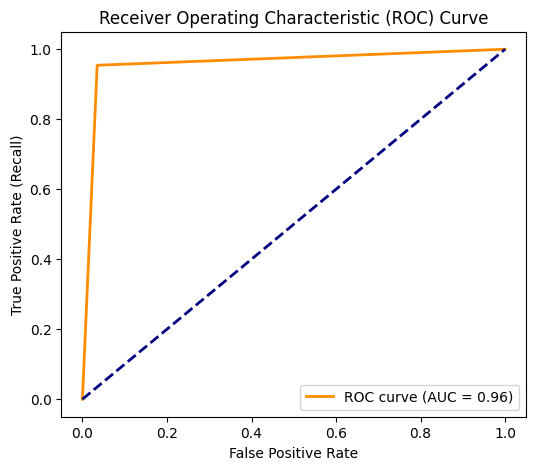

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(all_targets, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

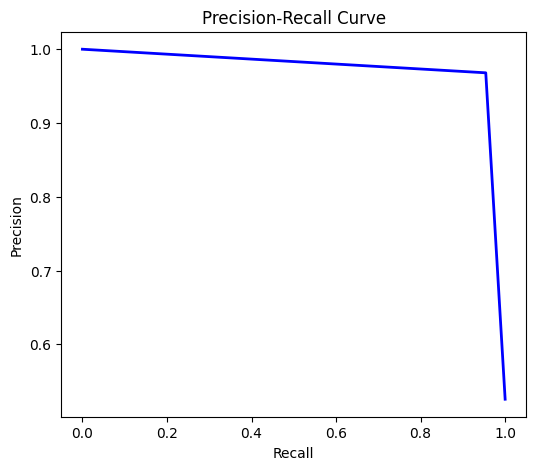

In [ ]:
from sklearn.metrics import precision_recall_curve

# Use predicted probabilities for class 'PD' here
# precision_vals, recall_vals, _ = precision_recall_curve(all_targets, all_probabilities)
precision_vals, recall_vals, _ = precision_recall_curve(all_targets, all_preds)

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


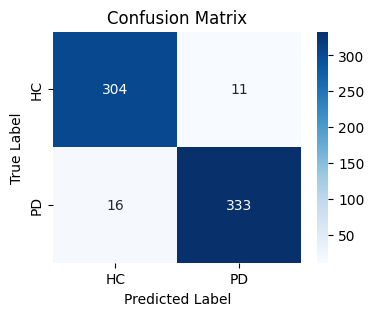

In [ ]:
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
